Training Multi-Agent DQN for TSP with 15 cities and 3 agents...
Episode 0/500 | Total Reward: -6.00 | Max Time: 274.15 | Epsilon: 0.9950
Episode 10/500 | Total Reward: -6.00 | Max Time: 367.99 | Epsilon: 0.9464
Episode 20/500 | Total Reward: -6.00 | Max Time: 274.00 | Epsilon: 0.9001
Episode 30/500 | Total Reward: -6.00 | Max Time: 317.20 | Epsilon: 0.8561
Episode 40/500 | Total Reward: -0.90 | Max Time: 284.38 | Epsilon: 0.8142
Episode 50/500 | Total Reward: -16.20 | Max Time: 235.68 | Epsilon: 0.7744
Episode 60/500 | Total Reward: -0.90 | Max Time: 323.54 | Epsilon: 0.7366
Episode 70/500 | Total Reward: -6.00 | Max Time: 358.65 | Epsilon: 0.7005
Episode 80/500 | Total Reward: 4.20 | Max Time: 403.03 | Epsilon: 0.6663
Episode 90/500 | Total Reward: 4.20 | Max Time: 347.30 | Epsilon: 0.6337
Episode 100/500 | Total Reward: -11.10 | Max Time: 248.71 | Epsilon: 0.6027
Episode 110/500 | Total Reward: 19.50 | Max Time: 388.24 | Epsilon: 0.5733
Episode 120/500 | Total Reward: 4.20 | Max Time

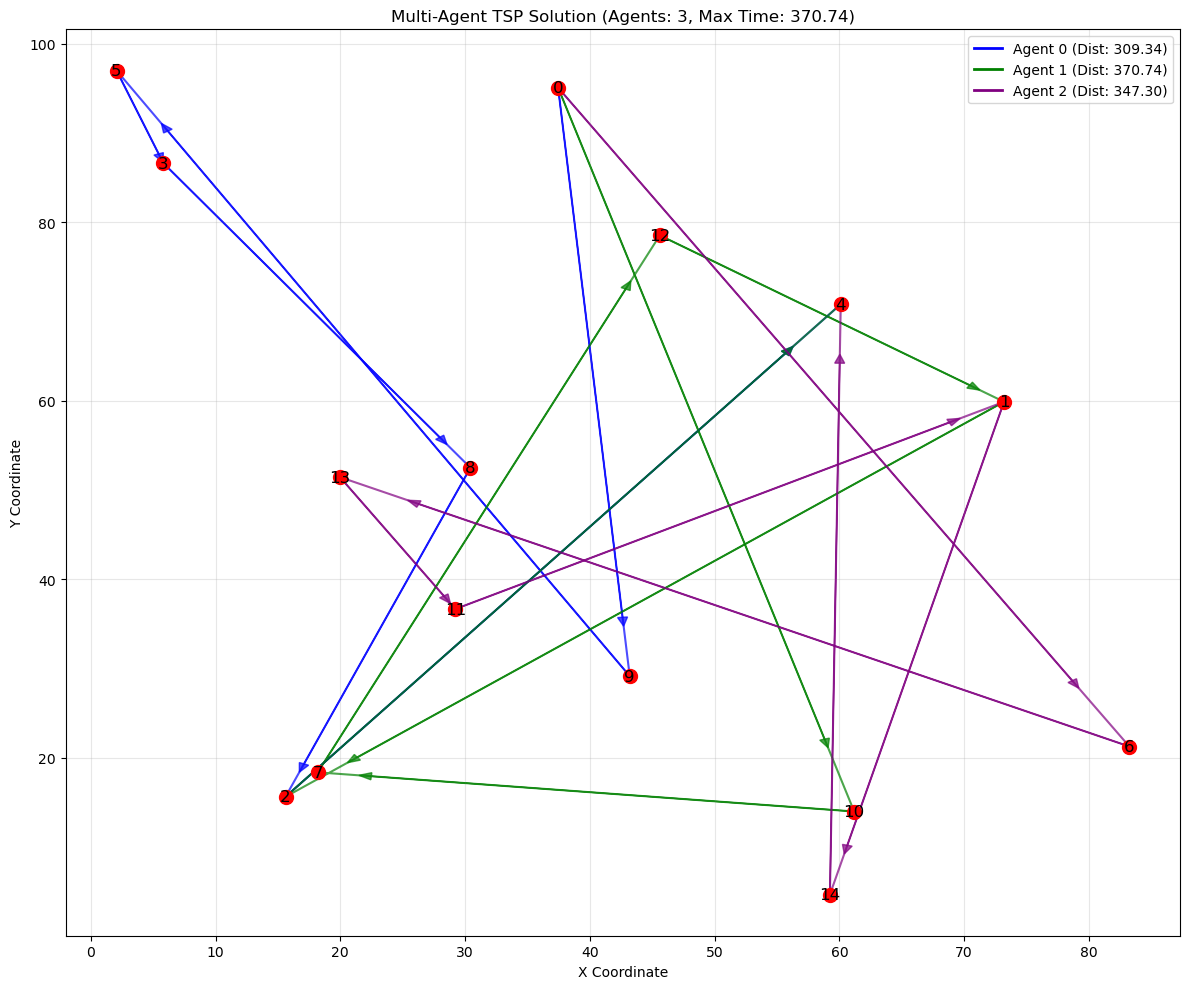

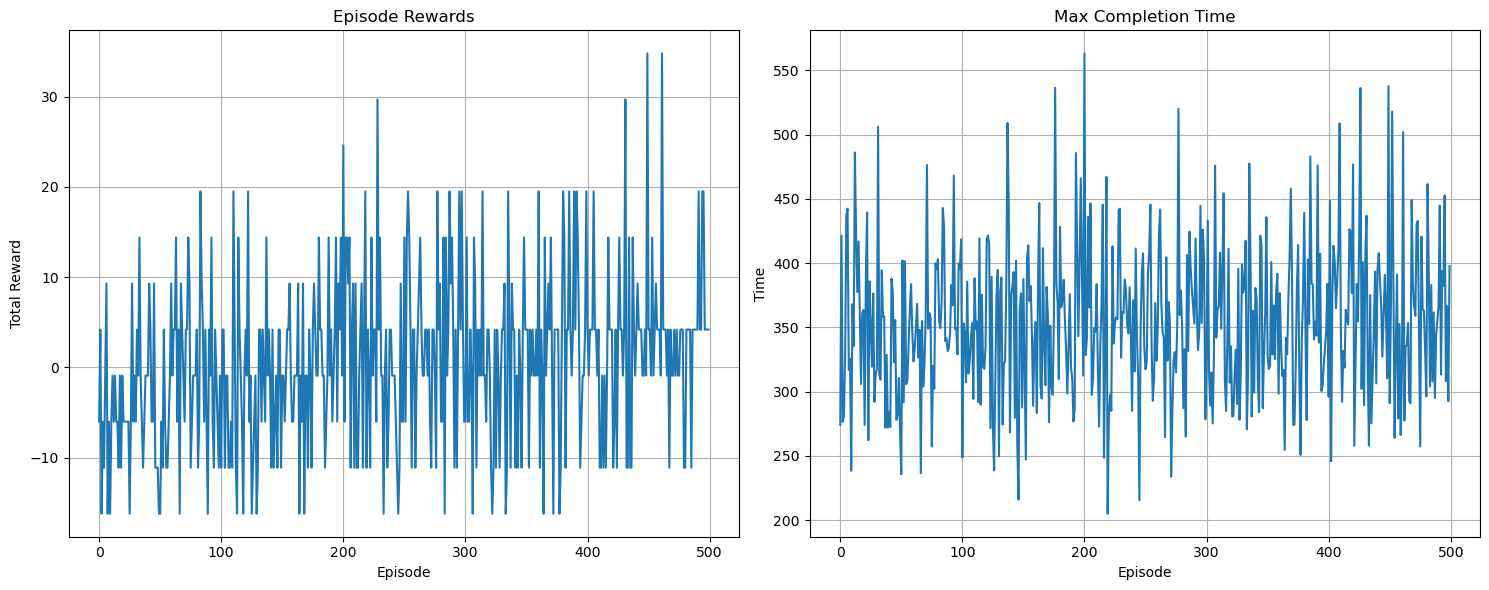

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import copy

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义经验回放缓冲区
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, *args):
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

# 定义DQN网络
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# 多智能体TSP环境
class MultiAgentTSPEnv:
    def __init__(self, cities, n_agents):
        self.cities = np.array(cities)
        self.n_cities = len(cities)
        self.n_agents = n_agents
        self.distances = distance_matrix(self.cities, self.cities)
        
        # 起点：城市0
        self.start_city = 0
        
        self.reset()
    
    def reset(self):
        # 所有智能体都在起点
        self.agent_positions = [self.start_city] * self.n_agents
        
        # 访问状态：起点已经被访问（因为所有智能体都在起点）
        self.visited = np.zeros(self.n_cities, dtype=bool)
        self.visited[self.start_city] = True
        
        # 记录每个智能体的路径和总距离
        self.paths = [[self.start_city] for _ in range(self.n_agents)]
        self.total_distances = np.zeros(self.n_agents)
        
        # 记录每个智能体是否完成
        self.completed = [False] * self.n_agents
        
        self.steps = 0
        self.done = False
        
        return self._get_state()
    
    def _get_state(self):
        # 状态包括：
        # 1. 所有智能体的当前位置 (n_agents 维)
        # 2. 城市访问状态 (n_cities 维)
        # 3. 每个智能体的完成状态 (n_agents 维)
        # 4. 每个智能体已访问的城市数 (n_agents 维)
        
        state = np.concatenate([
            np.array(self.agent_positions) / (self.n_cities - 1),  # 归一化位置
            self.visited.astype(float),
            np.array(self.completed).astype(float),
            np.array([len(set(path)) for path in self.paths]) / self.n_cities  # 归一化访问数
        ])
        return state
    
    def step(self, actions):
        rewards = np.zeros(self.n_agents)
        new_positions = self.agent_positions.copy()
        
        # 记录哪些城市被访问了（用于更新访问状态）
        visited_this_step = np.zeros(self.n_cities, dtype=bool)
        
        # 处理每个智能体的动作
        for i, action in enumerate(actions):
            if self.completed[i]:
                # 已完成任务的智能体不执行动作
                continue
                
            if action < self.n_cities:  # 移动到新城市
                target_city = action
                
                # 计算移动距离
                dist = self.distances[self.agent_positions[i]][target_city]
                self.total_distances[i] += dist
                
                # 更新位置
                new_positions[i] = target_city
                self.paths[i].append(target_city)
                
                # 如果访问了新城市
                if not self.visited[target_city]:
                    # 给予探索奖励
                    rewards[i] += 5.0
                    visited_this_step[target_city] = True
            else:  # 停留在原地
                # 轻微惩罚停留
                rewards[i] -= 0.1
        
        # 更新访问状态
        self.visited = np.logical_or(self.visited, visited_this_step)
        
        # 更新位置
        self.agent_positions = new_positions
        
        # 检查智能体是否完成
        for i in range(self.n_agents):
            if not self.completed[i] and len(set(self.paths[i])) == self.n_cities:
                self.completed[i] = True
                # 完成奖励
                rewards[i] += 20.0
        
        # 检查是否所有智能体都完成了任务
        if all(self.completed):
            self.done = True
            # 基于最大完成时间给予最终奖励
            max_distance = np.max(self.total_distances)
            # 最大完成时间越小，奖励越大
            final_reward = 100.0 / (1.0 + max_distance)
            rewards += final_reward
        
        # 时间惩罚（鼓励快速完成）
        rewards -= 0.1
        
        # 增加步数
        self.steps += 1
        
        # 如果超过最大步数，结束episode
        if self.steps > self.n_cities * 3:
            self.done = True
            # 未完成的惩罚
            for i, comp in enumerate(self.completed):
                if not comp:
                    rewards[i] -= 20.0
        
        return self._get_state(), rewards, self.done, self.total_distances

# 多智能体DQN
class MultiAgentDQN:
    def __init__(self, state_dim, action_dim, n_agents, 
                 learning_rate=0.001, gamma=0.99, epsilon_start=1.0, 
                 epsilon_end=0.01, epsilon_decay=0.995, buffer_capacity=10000, 
                 batch_size=64, target_update=10):
        
        self.n_agents = n_agents
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update
        
        # 为每个智能体创建Q网络和目标网络
        self.policy_nets = [DQN(state_dim, action_dim).to(device) for _ in range(n_agents)]
        self.target_nets = [DQN(state_dim, action_dim).to(device) for _ in range(n_agents)]
        
        for i in range(n_agents):
            self.target_nets[i].load_state_dict(self.policy_nets[i].state_dict())
            self.target_nets[i].eval()
        
        # 优化器
        self.optimizers = [optim.Adam(net.parameters(), lr=learning_rate) for net in self.policy_nets]
        
        # 经验回放缓冲区（共享）
        self.memory = ReplayBuffer(buffer_capacity)
        
        self.steps_done = 0
    
    def select_action(self, state, valid_actions_mask=None):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        actions = []
        for i in range(self.n_agents):
            # 使用epsilon-贪婪策略
            if np.random.random() < self.epsilon:
                # 随机选择有效动作
                if valid_actions_mask is not None:
                    valid_actions = np.where(valid_actions_mask[i])[0]
                    action = np.random.choice(valid_actions) if len(valid_actions) > 0 else self.action_dim - 1
                else:
                    action = np.random.randint(self.action_dim)
            else:
                # 选择Q值最大的动作
                with torch.no_grad():
                    q_values = self.policy_nets[i](state_tensor).cpu().numpy().squeeze()
                
                # 屏蔽无效动作
                if valid_actions_mask is not None:
                    q_values[~valid_actions_mask[i]] = -np.inf
                
                action = np.argmax(q_values)
            
            actions.append(action)
        
        return actions
    
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        
        # 转换数据为张量
        state_batch = torch.FloatTensor(np.array(batch.state)).to(device)
        action_batch = torch.LongTensor(np.array(batch.action)).to(device)
        reward_batch = torch.FloatTensor(np.array(batch.reward)).to(device)
        next_state_batch = torch.FloatTensor(np.array(batch.next_state)).to(device)
        done_batch = torch.FloatTensor(np.array(batch.done)).to(device)
        
        # 为每个智能体优化
        for agent_idx in range(self.n_agents):
            # 计算当前Q值
            state_action_values = self.policy_nets[agent_idx](state_batch).gather(1, action_batch[:, agent_idx].unsqueeze(1))
            
            # 计算下一个状态的最大Q值
            next_state_values = self.target_nets[agent_idx](next_state_batch).max(1)[0].detach()
            
            # 计算期望Q值
            expected_state_action_values = (next_state_values * self.gamma * (1 - done_batch)) + reward_batch[:, agent_idx]
            
            # 计算Huber损失
            loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
            
            # 优化模型
            self.optimizers[agent_idx].zero_grad()
            loss.backward()
            
            # 梯度裁剪
            for param in self.policy_nets[agent_idx].parameters():
                param.grad.data.clamp_(-1, 1)
            
            self.optimizers[agent_idx].step()
    
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def update_target_networks(self):
        for i in range(self.n_agents):
            self.target_nets[i].load_state_dict(self.policy_nets[i].state_dict())
    
    def save_models(self, path_prefix):
        for i in range(self.n_agents):
            torch.save(self.policy_nets[i].state_dict(), f"{path_prefix}_agent_{i}.pth")
    
    def load_models(self, path_prefix):
        for i in range(self.n_agents):
            self.policy_nets[i].load_state_dict(torch.load(f"{path_prefix}_agent_{i}.pth"))
            self.target_nets[i].load_state_dict(self.policy_nets[i].state_dict())

# 训练函数
def train_multi_agent_tsp(cities, n_agents, episodes=1000, batch_size=64, 
                          target_update_freq=10, save_freq=100):
    # 创建环境
    env = MultiAgentTSPEnv(cities, n_agents)
    
    # 状态和动作维度
    state_dim = len(env._get_state())
    action_dim = env.n_cities + 1  # 可以移动到任何城市或停留
    
    # 创建多智能体DQN
    maddqn = MultiAgentDQN(
        state_dim=state_dim,
        action_dim=action_dim,
        n_agents=n_agents,
        batch_size=batch_size,
        target_update=target_update_freq
    )
    
    # 记录训练统计信息
    episode_rewards = []
    episode_max_times = []
    epsilon_history = []
    
    for episode in range(episodes):
        state = env.reset()
        total_rewards = np.zeros(n_agents)
        done = False
        
        while not done:
            # 获取有效动作掩码（只能移动到未访问的城市或停留）
            valid_actions_mask = np.zeros((n_agents, action_dim), dtype=bool)
            for i in range(n_agents):
                # 停留总是有效的
                valid_actions_mask[i, -1] = True
                
                # 如果智能体未完成，可以移动到未访问的城市
                if not env.completed[i]:
                    for city in range(env.n_cities):
                        if not env.visited[city]:
                            valid_actions_mask[i, city] = True
            
            # 选择动作
            actions = maddqn.select_action(state, valid_actions_mask)
            
            # 执行动作
            next_state, rewards, done, distances = env.step(actions)
            
            # 存储经验
            maddqn.memory.push(state, actions, next_state, rewards, done)
            
            # 优化模型
            maddqn.optimize_model()
            
            # 更新状态和奖励
            state = next_state
            total_rewards += rewards
        
        # 更新目标网络
        if episode % target_update_freq == 0:
            maddqn.update_target_networks()
        
        # 更新epsilon
        maddqn.update_epsilon()
        
        # 记录统计信息
        episode_rewards.append(np.sum(total_rewards))
        episode_max_times.append(np.max(distances))
        epsilon_history.append(maddqn.epsilon)
        
        # 保存模型
        if episode % save_freq == 0:
            maddqn.save_models(f"multi_agent_dqn_ep_{episode}")
        
        # 打印进度
        if episode % 10 == 0:
            print(f"Episode {episode}/{episodes} | Total Reward: {np.sum(total_rewards):.2f} | "
                  f"Max Time: {np.max(distances):.2f} | Epsilon: {maddqn.epsilon:.4f}")
    
    # 返回训练结果
    return {
        "rewards": episode_rewards,
        "max_times": episode_max_times,
        "epsilon": epsilon_history,
        "model": maddqn,
        "env": env
    }

# 评估函数
def evaluate_multi_agent(model, env):
    state = env.reset()
    done = False
    paths = [[] for _ in range(model.n_agents)]
    positions = [[] for _ in range(model.n_agents)]
    total_distances = np.zeros(model.n_agents)
    
    while not done:
        # 获取有效动作掩码
        valid_actions_mask = np.zeros((model.n_agents, model.action_dim), dtype=bool)
        for i in range(model.n_agents):
            valid_actions_mask[i, -1] = True  # 停留总是有效的
            if not env.completed[i]:
                for city in range(env.n_cities):
                    if not env.visited[city]:
                        valid_actions_mask[i, city] = True
        
        # 选择动作（贪婪策略）
        actions = model.select_action(state, valid_actions_mask)
        
        # 执行动作
        next_state, rewards, done, distances = env.step(actions)
        
        # 记录路径和位置
        for i in range(model.n_agents):
            paths[i] = env.paths[i].copy()
            positions[i].append(env.agent_positions[i])
            total_distances[i] = env.total_distances[i]
        
        state = next_state
    
    # 计算最大完成时间
    max_time = np.max(total_distances)
    
    return {
        "paths": paths,
        "positions": positions,
        "distances": total_distances,
        "max_time": max_time,
        "visited": env.visited.copy()
    }

# 可视化函数
def visualize_multi_agent_solution(cities, paths, distances, max_time):
    plt.figure(figsize=(12, 10))
    
    # 绘制城市
    plt.scatter(cities[:, 0], cities[:, 1], c='red', s=100, zorder=5)
    for i, city in enumerate(cities):
        plt.text(city[0], city[1], f"{i}", fontsize=12, ha='center', va='center', zorder=10)
    
    # 定义不同智能体的颜色
    colors = ['blue', 'green', 'purple', 'orange', 'cyan', 'magenta']
    
    # 绘制路径
    for i, path in enumerate(paths):
        color = colors[i % len(colors)]
        path_cities = np.array([cities[p] for p in path])
        
        # 绘制路径线
        plt.plot(path_cities[:, 0], path_cities[:, 1], color=color, linewidth=1.5, alpha=0.7)
        
        # 绘制路径点
        plt.scatter(path_cities[:, 0], path_cities[:, 1], color=color, s=50, alpha=0.7)
        
        # 添加箭头
        for j in range(len(path) - 1):
            start = path_cities[j]
            end = path_cities[j+1]
            dx = end[0] - start[0]
            dy = end[1] - start[1]
            plt.arrow(start[0], start[1], dx*0.9, dy*0.9, 
                      head_width=0.8, head_length=1.0, 
                      fc=color, ec=color, alpha=0.7)
    
    # 添加标题和信息
    plt.title(f"Multi-Agent TSP Solution (Agents: {len(paths)}, Max Time: {max_time:.2f})")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True, alpha=0.3)
    
    # 添加图例
    legend_handles = []
    for i in range(len(paths)):
        color = colors[i % len(colors)]
        legend_handles.append(plt.Line2D([0], [0], color=color, lw=2, 
                                        label=f"Agent {i} (Dist: {distances[i]:.2f})"))
    plt.legend(handles=legend_handles)
    
    plt.tight_layout()
    plt.show()

# 主程序
if __name__ == "__main__":
    # 设置参数
    n_cities = 15
    n_agents = 3
    episodes = 500
    
    # 生成城市坐标
    np.random.seed(42)
    cities = np.random.rand(n_cities, 2) * 100
    
    # 训练多智能体DQN
    print(f"Training Multi-Agent DQN for TSP with {n_cities} cities and {n_agents} agents...")
    training_results = train_multi_agent_tsp(
        cities=cities,
        n_agents=n_agents,
        episodes=episodes,
        batch_size=128,
        target_update_freq=20
    )
    
    # 获取训练后的模型和环境
    maddqn = training_results["model"]
    env = training_results["env"]
    
    # 评估模型
    print("\nEvaluating trained model...")
    eval_results = evaluate_multi_agent(maddqn, env)
    
    # 输出结果
    print("\nEvaluation Results:")
    print(f"Max Completion Time: {eval_results['max_time']:.2f}")
    for i, (path, dist) in enumerate(zip(eval_results['paths'], eval_results['distances'])):
        print(f"Agent {i} Path: {path} | Distance: {dist:.2f}")
    
    # 可视化解决方案
    print("\nVisualizing solution...")
    visualize_multi_agent_solution(
        cities=cities,
        paths=eval_results['paths'],
        distances=eval_results['distances'],
        max_time=eval_results['max_time']
    )
    
    # 绘制训练曲线
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(training_results["rewards"])
    plt.title("Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(training_results["max_times"])
    plt.title("Max Completion Time")
    plt.xlabel("Episode")
    plt.ylabel("Time")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()